<a href="https://colab.research.google.com/github/kumagaimasahito/2019/blob/master/ExtremeClustering_QA/QA/QA_BiDViT_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data Visualization Tool by QA
Evaluation of BiDViT based on approach to QA.  

## 準備
- ライブラリのインストール
- データの準備

In [0]:
!pip install dwave-ocean-sdk

     |████████████████████████████████| 92kB 2.6MB/s 
     |████████████████████████████████| 204kB 8.3MB/s 
     |████████████████████████████████| 13.9MB 165kB/s 
     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 788kB 36.5MB/s 
     |████████████████████████████████| 839kB 46.8MB/s 
     |████████████████████████████████| 399kB 49.5MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 2.3MB 43.5MB/s 
     |████████████████████████████████| 81kB 4.5MB/s 
     |████████████████████████████████| 23.7MB 99kB/s 
     |████████████████████████████████| 235kB 43.4MB/s 
  Created wheel for pyqubo: filename=pyqubo-0.4.0-cp36-none-any.whl size=40711 sha256=e9c0ac0f00f2753b9ffec065dfe667c9b695648f0352f8905d63ee9b9ea3a528
  Stored in directory: /root/.cache/pip/wheels/77/b7/47/b989889699f788f4fecdc534bfddbb16df9a9a51f4e431b04d
Successfully built pyqubo
ERROR: tensorflow 1.15.0 has requirement numpy<2.0,>=1

In [0]:
# ライブラリのインポート
import numpy as np
import networkx as nx
import dwave_networkx as dnx
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import pandas as pd
from matplotlib import pyplot as plt
import time
from scipy.spatial import distance
from sklearn.datasets import load_iris
iris = load_iris()

In [0]:
# pd.DataFrame -> numpy array
data = np.array(iris.data)

In [0]:
weight = [1] * len(data)

In [0]:
answer = iris.target

## BiDViT Computation Time Measure Function

In [0]:
# Data Partitioning

"vinary median cut by variance"
def vinary_medcut(data):
  var_data = np.var(data, axis=0)
  med_data = np.median(data, axis=0)

  chunk = [0] * len(data)
  dimension = len(data[0])

  flag = 0
  label = 0
  rep_d = 0

  for i in range(len(data)):
    if len(data)%2 == 1: # number of datapoints is odd.
      for d in range(dimension):
        if var_data[d] >= var_data[rep_d]: # variance of dimennsion >= variance of representive dimension
          rep_d = d
      if med_data[rep_d] >=  data[:,rep_d][i]: # if median of representive dimension >= every data, every chunk is determined below. 
        chunk[i] = label
      elif med_data[rep_d] <  data[:,rep_d][i]: # if median of representive dimension < every data, every chunk is determined below.
        chunk[i] = label+1

    elif len(data)%2 == 0: # number of datapoints is even .
      for d in range(dimension):
        if var_data[d] >= var_data[rep_d]: # variance of dimennsion >= variance of representive dimension
          rep_d = d
      if med_data[rep_d] > data[:,rep_d][i]: # if median of representive dimension > every data, every chunk is determined below.
        chunk[i] = label
      elif med_data[rep_d] < data[:,rep_d][i]: # if median of representive dimension < every data, every chunk is determined below.
        chunk[i] = label+1
      elif med_data[rep_d] == data[:,rep_d][i]: # if median of representive dimension = a data the former and latter 's label are different.
        if flag == 0: # the former's label is below.
          chunk[i] = label
          flag += 1
        elif flag == 1: # the latter's label is below.
          chunk[i] = label+1
          flag == 0

  return chunk


"main function of median cut based on variance"
def var_medcut(data,kappa):
  chunk = vinary_medcut(data)
  prev_label = 2
  max_points = np.count_nonzero([i for i, x in enumerate(chunk) if x == 0], axis=0)

  while (max_points > kappa):

    # get the max data points of any chunks ,the max data points chunks label number
    max_points = np.count_nonzero([i for i, x in enumerate(chunk) if x == 0], axis=0)
    label_max_data = 0
    for j in range(prev_label):
      prev_points = np.count_nonzero([i for i, x in enumerate(chunk) if x == j], axis=0)
      if prev_points >= max_points:
        max_points = prev_points
        label_max_data = j
    if max_points <= kappa:
      break
    
    # vinary median cut targeted to the max variance chunk
    prev_data = np.delete(data, [i for i, x in enumerate(chunk) if not x == label_max_data], axis=0) # data of max variance chunk
    prev_chunk = vinary_medcut(prev_data)

    # update chunk number
    prev_chunk = [label_max_data if i == 0 else prev_label for i in prev_chunk]
    tmp = 0
    for i in range(len(chunk)):
      if chunk[i] == label_max_data:
        chunk[i] = prev_chunk[tmp]
        tmp += 1

    prev_label += 1

  return chunk



# Chunk Coarsening

"solve the Neighborhood matrix of data chunks"
def N_solver(data_chunk, epsilon):
  dist_matrix = distance.cdist(data_chunk, data_chunk, metric='euclidean')
  N = np.identity(len(data_chunk))

  for i in range(len(data_chunk)):
    for j in range(len(data_chunk)):
      if j == i:
        continue
      elif i < j:
        if dist_matrix[i][j] < epsilon:
          N[i][j] = 1
        else:
          N[i][j] = 0

  return N


"determin collection coefficient : rev"
def rev_solver(weight, rev_rate=1.1):
  rev = np.zeros((len(weight), len(weight)))
  for i in range(len(weight)):
    for j in range(len(weight)):
      if i == j:
        continue
      elif i < j:
        rev[i][j] = max(weight[i],weight[j]) * rev_rate
  
  return rev


"MWIS --> QUBO"
def MtoQ(data_chunk, weight, epsilon, rev_rate=1.1):
  coarsening1_start = time.time()
  N = N_solver(data_chunk, epsilon)
  rev = rev_solver(weight, rev_rate)
  Q = {}
  for i in range(len(weight)):
    Q[(i,i)] = 0

  for i in range(len(data_chunk)):
    for j in range(len(data_chunk)):
      if i == j:
        Q[(i,j)] = -1 * weight[i]
      elif N[i][j] == 1 and i < j:
        Q[(i,j)] = rev[i][j]
  coarsening1_end = time.time()
  coarsening1_time = coarsening1_end - coarsening1_start
  return Q, coarsening1_time


"Only rewrite this function to change the QUBO solver"
def qubo_solver_QA(qubo):
    sampler = EmbeddingComposite(DWaveSampler(endpoint='https://cloud.dwavesys.com/sapi', token="DEV-7e439a945f84ac3496a7ed481d73c3ed6ac728df", solver='DW_2000Q_2_1'))
    response = sampler.sample_qubo(qubo, num_reads=1)
    solutions = response.record['sample'][np.argmin(response.record['energy'])]
    coarsening2_time = response.info['timing']['qpu_access_time'] * (10 ** (-6))
    return solutions, coarsening2_time


"The complete set for the chunk coarsening part"
def coarsening_set_QA(data_chunk, weight, epsilon, rev_rate=1.1):
    qubo, coarsening1_time = MtoQ(data_chunk, weight, epsilon, rev_rate)
    solutions, coarsening2_time = qubo_solver_QA(qubo)
    return solutions, coarsening1_time, coarsening2_time



# Chunk Collapsing

"Solve new weight"
def w_updater_QA(data_chunk, weight_chunk, solutions):
  S = np.delete(data_chunk, [i for i, x in enumerate(solutions) if x == 0], axis=0)
  P = data_chunk
  weight_cent = [0] * len(S)

  dist_matrix = distance.cdist(S, P, metric='euclidean')
  np.fill_diagonal(dist_matrix, np.inf)
  nearest = np.argmin(dist_matrix, axis=0)
  centroids = S

  for j in range(len(S)):
    for i in range(len(weight_chunk)):
      if nearest[i] == j:
        weight_cent[j] += weight_chunk[i]

  flag = 0
  for j in [i for i, x in enumerate(solutions) if x == 1]:
    weight_cent[flag] += weight_chunk[j]
    flag += 1

  return centroids, weight_cent, nearest


"All Chunk Collapsing"
def all_w_updater_QA(data, chunk_label, weight, epsilon=0.4, rev_rate=1.1):
  coarsening1_time = 0
  coarsening2_time = 0
  collapsing_time = 0
  collapsing_start = time.time()
  
  chunk_set = [0] * (max(chunk_label) + 1)
  chunk_weight = [0] * (len(chunk_set))
  solutions = [0] * (len(chunk_set))
  centroids = [0] * (len(chunk_set))
  weight_cent = [0] * (len(chunk_set))
  nearest = [0] * (len(chunk_set))

  for chunk_num in range(len(chunk_set)):
    chunk_set = np.delete(data, [i for i, x in enumerate(chunk_label) if not x == chunk_num], axis=0)
    chunk_weight = np.delete(weight, [i for i, x in enumerate(chunk_label) if not x == chunk_num], axis=0)
    solutions[chunk_num], t1, t2 = coarsening_set_QA(chunk_set, chunk_weight, epsilon, rev_rate)
    centroids[chunk_num], weight_cent[chunk_num], nearest[chunk_num] = w_updater_QA(chunk_set, chunk_weight, solutions[chunk_num])
    coarsening1_time += t1
    coarsening2_time += t2
  collapsing_end = time.time()
  collapsing_time = collapsing_end - collapsing_start - coarsening1_time - coarsening2_time

  return solutions, centroids, weight_cent, nearest, coarsening1_time, coarsening2_time, collapsing_time



# Big Data Visualization Tool

"Measure computation time on BiDViT"
def time_BiDViT_QA(data, weight, required_level=10, kappa=64, epsilon=0.4, ep_rate=2.0, rev_rate=1.1, esc=False):
  raw_data_sum = len(data)
  tree_list = []
  data_list = []
  weight_list = []
  level = 0

  partition_time = 0
  coarsening1_time = 0
  coarsening2_time = 0
  collapsing_time = 0
  partition_time_list = []
  coarsening1_time_list = []
  coarsening2_time_list = []
  collapsing_time_list = []

  while (level < required_level):
    data_list.append(data)
    weight_list.append(weight)

    partition_start = time.time()
    chunk= var_medcut(data,kappa)
    partition_end = time.time()
    partition_time += partition_end - partition_start

    solutions, centroids, weight_cent, nearest, t1, t2, t3 = all_w_updater_QA(data, chunk, weight, epsilon, rev_rate)
    coarsening1_time += t1
    coarsening2_time += t2
    collapsing_time += t3

    next_data_sum = 0
    for i in range(len(nearest)):
      next_data_sum += len(centroids[i])
    
    next_data = [0] * next_data_sum
    next_weight = [0] * next_data_sum

    flag = 0
    for i in range(len(nearest)):
      for j in range(len(centroids[i])):
        next_data[j+flag] = centroids[i][j]
        next_weight[j+flag] = weight_cent[i][j]
      flag += len(centroids[i])
    
    cluster = [0] * len(chunk)

    for i in range(len(nearest)-1):
      nearest[i+1] += max(nearest[i])+1

    tmp = [0] * len(nearest)
    for i in range(len(chunk)):
      cluster[i] = nearest[chunk[i]][tmp[chunk[i]]]
      tmp[chunk[i]] += 1

    tree_list.append(cluster)
    level += 1

    partition_time_list.append(partition_time)
    coarsening1_time_list.append(coarsening1_time)
    coarsening2_time_list.append(coarsening2_time)
    collapsing_time_list.append(collapsing_time)

    if (esc==False) and (len(data) == len(next_data)):
      break
    data = np.array(next_data)
    weight = next_weight

    epsilon = ep_rate * epsilon

  return tree_list, data_list, weight_list, level, partition_time_list, coarsening1_time_list, coarsening2_time_list, collapsing_time_list

In [0]:
# solve representative labels per each BiDViT level
def representer(tree_list):
  import copy
  represent_list = []
  for k in range(1, len(tree_list)+1):
      represent = copy.deepcopy(tree_list)
      for i in range(len(tree_list)-k, 0, -1):
        for j in range(len(tree_list[i-1])):
          represent[i-1][j] = represent[i][represent[i-1][j]]
      represent_list.append(np.array(represent[0]))
  for i in range(len(represent_list) // 2): # reverse the list
      represent_list[i],represent_list[-1-i] = represent_list[-1-i],represent_list[i]
  return represent_list

In [0]:
# solve some evaluation score
def score_func(data, represent_list):
  from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
  silhouette_coefficient_list = []
  calinski_harabasz_index_list = []
  davies_bouldin_index_list = []
  cluster_list = []
  for i in range(len(represent_list)):
    silhouette_coefficient_list.append(silhouette_score(data, represent_list[i]))
    calinski_harabasz_index_list.append(calinski_harabasz_score(data, represent_list[i]))
    davies_bouldin_index_list.append(davies_bouldin_score(data, represent_list[i]))
    cluster_list.append(max(represent_list[i]) + 1)
  return silhouette_coefficient_list, calinski_harabasz_index_list, davies_bouldin_index_list, cluster_list

In [0]:
# benchmark function for BiDViT
def benchmark_BiDViT_QA(data, weight, required_level=10, kappa=30, epsilon=1.0, ep_rate=1.3, rev_rate=1.1, esc=False, iteration=10):
  partition_time_QA = []
  coarsening1_time_QA = []
  coarsening2_time_QA = []
  collapsing_time_QA = []
  silhouette_coefficient_QA = []
  calinski_harabasz_index_QA = []
  davies_bouldin_index_QA = []
  cluster_QA = []
  for n in range(iteration):
    tree_list_QA, data_list_QA, weight_list_QA, level_QA, par, coa1, coa2, col = time_BiDViT_QA(data, weight, required_level, kappa, epsilon, ep_rate, rev_rate, esc)
    represent_list_QA = representer(tree_list_QA)
    sil, cal, dav, clu = score_func(data, represent_list_QA)
    partition_time_QA.extend(par)
    coarsening1_time_QA.extend(coa1)
    coarsening2_time_QA.extend(coa2)
    collapsing_time_QA.extend(col)
    silhouette_coefficient_QA.extend(sil)
    calinski_harabasz_index_QA.extend(cal)
    davies_bouldin_index_QA.extend(dav)
    cluster_QA.extend(clu)
  time_all_QA = np.array(partition_time_QA) + np.array(coarsening1_time_QA) + np.array(coarsening2_time_QA) + np.array(collapsing_time_QA)

  cluflag = -1
  clurep = []
  for i, x in enumerate(sorted(cluster_QA)):
    if cluflag != x:
      clurep.append(x)
      cluflag = x

  time_par_ave = [0] * len(clurep)
  time_coa1_ave = [0] * len(clurep)
  time_coa2_ave = [0] * len(clurep)
  time_col_ave = [0] * len(clurep)
  time_all_ave = [0] * len(clurep)
  score_sil_ave = [0] * len(clurep)
  score_cal_ave = [0] * len(clurep)
  score_dav_ave = [0] * len(clurep)
  for j, c in enumerate(clurep):
    for i, x in enumerate(cluster_QA):
      if x == c:
        time_par_ave[j] += partition_time_QA[i]
        time_coa1_ave[j] += coarsening1_time_QA[i]
        time_coa2_ave[j] += coarsening2_time_QA[i]
        time_col_ave[j] += collapsing_time_QA[i]
        time_all_ave[j] += time_all_QA[i]
        score_sil_ave[j] += silhouette_coefficient_QA[i]
        score_cal_ave[j] += calinski_harabasz_index_QA[i]
        score_dav_ave[j] += davies_bouldin_index_QA[i]
    time_par_ave[j] = time_par_ave[j] / len([i for i, x in enumerate(cluster_QA) if x == c])
    time_coa1_ave[j] = time_coa1_ave[j] / len([i for i, x in enumerate(cluster_QA) if x == c])
    time_coa2_ave[j] = time_coa2_ave[j] / len([i for i, x in enumerate(cluster_QA) if x == c])
    time_col_ave[j] = time_col_ave[j] / len([i for i, x in enumerate(cluster_QA) if x == c])
    time_all_ave[j] = time_all_ave[j] / len([i for i, x in enumerate(cluster_QA) if x == c])
    score_sil_ave[j] = score_sil_ave[j] / len([i for i, x in enumerate(cluster_QA) if x == c])
    score_cal_ave[j] = score_cal_ave[j] / len([i for i, x in enumerate(cluster_QA) if x == c])
    score_dav_ave[j] = score_dav_ave[j] / len([i for i, x in enumerate(cluster_QA) if x == c])

  return {
      "cluster": clurep,
      "time": {
          "partition": time_par_ave,
          "coarsening1": time_coa1_ave,
          "coarsening2": time_coa2_ave,
          "collapsing": time_col_ave,
          "all": time_all_ave
      },
      "score": {
          "silhouette_coef": score_sil_ave,
          "calinski_harabasz": score_cal_ave,
          "davies_bouldin": score_dav_ave
      }
  }

## Evaluation

Environment
- Google Colab

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
result = benchmark_BiDViT_QA(data, weight, required_level=10, kappa=30, epsilon=1.0, ep_rate=1.3, rev_rate=1.1, esc=False, iteration=1)

KeyboardInterrupt: ignored

NameError: ignored

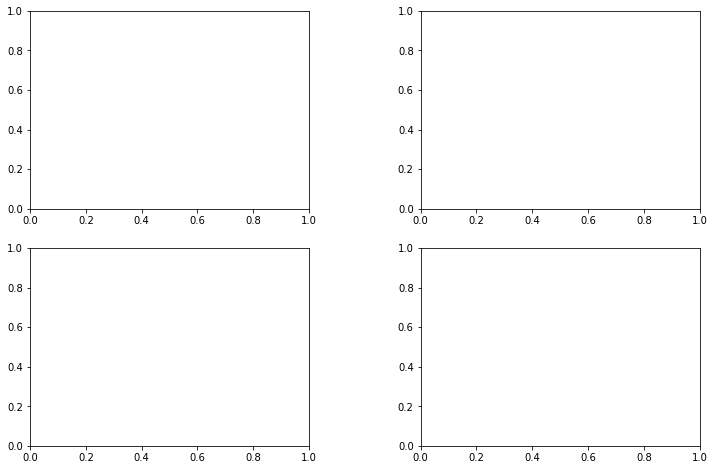

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
plt.subplots_adjust(wspace=0.4)

fontsize = 10
axes[0,0].plot(result["cluster"], result["time"]["all"], color = 'black')
axes[0,0].set_xlabel('cluster', fontsize=fontsize)
axes[0,0].set_ylabel('Total time', fontsize=fontsize)

axes[0,1].plot(result["cluster"], result["score"]["silhouette_coef"], color = 'black')
axes[0,1].set_xlabel('cluster', fontsize=fontsize)
axes[0,1].set_ylabel('silhouette coefficient', fontsize=fontsize)

axes[1,0].plot(result["cluster"], result["score"]["calinski_harabasz"], color = 'black')
axes[1,0].set_xlabel('cluster', fontsize=fontsize)
axes[1,0].set_ylabel('calinski harabasz index', fontsize=fontsize)

axes[1,1].plot(result["cluster"], result["score"]["davies_bouldin"], color = 'black')
axes[1,1].set_xlabel('cluster', fontsize=fontsize)
axes[1,1].set_ylabel('davies bouldin index', fontsize=fontsize)

plt.show()

In [0]:
score = ['silhouette coefficient', 'calinski harabasz index', 'davies bouldin index']
cluster = result["cluster"]

dataframe = [
             result["score"]["silhouette_coef"],
             result["score"]["calinski_harabasz"],
             result["score"]["davies_bouldin"]
]
df = pd.DataFrame(dataframe, index=score, columns=cluster)

# 表を画像として描画
fig,ax = plt.subplots(figsize=((len(df.columns)+1)*3.0, (len(df)+1)*0.4))
ax.axis('off')
tbl = ax.table(cellText=df.values,
               bbox=[0,0,1,1],
               colLabels=df.columns,
               rowLabels=df.index)

plt.show()

NameError: ignored